In [2]:
# !pip install arch

#thought I was going to use/need this, turns out not for now. 

In [3]:
#import a whole bunch of stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox




WARNING: NEED TO UPDATE THE CSV FILE TO INCLUDE SECTOR. CURRENTLY DOES NOT

# Data
Let's first import the dataframe we want to work with and manipulate it a bit for easier handling

In [4]:
df= pd.read_csv('../data/news_data_2019_2024_sorted.csv')
df.head()
# df.info()

,Date & Time,Headline,Text,Source,News ID,URL,Ticker,Negative Sentiment Score,Neutral Sentiment Score,Positive Sentiment Score,Total Sentiment Score (Compound)
0,2019-03-15 06:46:42-04:00,Did Wells Fargo CEO Tim Sloan Earn His $1 Mill...,We learned this week that the scandal-plagued ...,The Motley Fool,15926,https://www.fool.com/investing/2019/03/14/did-...,WFC,0.000,0.931,0.069,0.2500
1,2019-03-15 06:47:26-04:00,Don't Underestimate Apple's iPhone Business,The segment is an invaluable asset to Apple's ...,The Motley Fool,15927,https://www.fool.com/investing/2019/03/14/dont...,AAPL,0.000,0.748,0.252,0.5248
2,2019-03-15 07:33:00-04:00,A Closer Look At Mastercard's Key Value Drivers,Mastercard has consistently beat street estima...,Forbes,17578,https://www.forbes.com/sites/greatspeculations...,MA,0.060,0.741,0.199,0.7269
3,2019-03-15 07:52:45-04:00,Jim Cramer Gives His Opinion On Bank Of Americ...,"On CNBC's ""Mad Money Lightning Round"", Jim Cra...",Benzinga,16064,https://feeds.benzinga.com/~r/benzinga/~3/Fwtd...,BAC,0.104,0.896,0.000,-0.5367
4,2019-03-15 09:29:39-04:00,Uber And Waymo Seeking Outside Funding For Aut...,Commercially viable autonomous vehicle (AV) te...,Benzinga,15695,https://feeds.benzinga.com/~r/benzinga/~3/fizU...,GOOGL,0.085,0.915,0.000,-0.4201


In [5]:
#which tickers are present
tickers = df['Ticker'].unique()

#change names of columns for ease
new_cols = {'Date & Time': 'Date', 'Negative Sentiment Score': 'Negative_SS', 'Neutral Sentiment Score': 
            'Neutral_SS', 'Positive Sentiment Score': 'Positive_SS', 'Total Sentiment Score (Compound)': 
             'Total_SS' }
df.rename(columns = new_cols, inplace = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63704 entries, 0 to 63703
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         63704 non-null  object 
 1   Headline     63704 non-null  object 
 2   Text         63704 non-null  object 
 3   Source       63704 non-null  object 
 4   News ID      63704 non-null  int64  
 5   URL          63704 non-null  object 
 6   Ticker       63704 non-null  object 
 7   Negative_SS  63704 non-null  float64
 8   Neutral_SS   63704 non-null  float64
 9   Positive_SS  63704 non-null  float64
 10  Total_SS     63704 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 5.3+ MB



Let's change the date column to datetime objects and remove the time.  

In [6]:
df['New_Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d %H:%M:%S%z', utc = True)

#Only keep the date 
df['New_Date']= df['New_Date'].apply(lambda x: x.date())
df['New_Date'] = pd.to_datetime(df['New_Date'])


For potential future use, let's also make a column that tells us if our total sentiment score is positive, negative, or neutral. For this, I will put a buffer of 
.1 around 0 to indicate neutrality. 

I will use -1, 0, 1 to indicate negative, neutral, and positive respectively. 

In [7]:
def label_sentiment(score:int):
    if score > .1:
        return 1
    elif score < -.1:
        return -1
    else:
        return 0

df['Label_SS'] = df['Total_SS'].apply(lambda x: label_sentiment(x))
df.head()

,Date,Headline,Text,Source,News ID,URL,Ticker,Negative_SS,Neutral_SS,Positive_SS,Total_SS,New_Date,Label_SS
0,2019-03-15 06:46:42-04:00,Did Wells Fargo CEO Tim Sloan Earn His $1 Mill...,We learned this week that the scandal-plagued ...,The Motley Fool,15926,https://www.fool.com/investing/2019/03/14/did-...,WFC,0.000,0.931,0.069,0.2500,2019-03-15,1
1,2019-03-15 06:47:26-04:00,Don't Underestimate Apple's iPhone Business,The segment is an invaluable asset to Apple's ...,The Motley Fool,15927,https://www.fool.com/investing/2019/03/14/dont...,AAPL,0.000,0.748,0.252,0.5248,2019-03-15,1
2,2019-03-15 07:33:00-04:00,A Closer Look At Mastercard's Key Value Drivers,Mastercard has consistently beat street estima...,Forbes,17578,https://www.forbes.com/sites/greatspeculations...,MA,0.060,0.741,0.199,0.7269,2019-03-15,1
3,2019-03-15 07:52:45-04:00,Jim Cramer Gives His Opinion On Bank Of Americ...,"On CNBC's ""Mad Money Lightning Round"", Jim Cra...",Benzinga,16064,https://feeds.benzinga.com/~r/benzinga/~3/Fwtd...,BAC,0.104,0.896,0.000,-0.5367,2019-03-15,-1
4,2019-03-15 09:29:39-04:00,Uber And Waymo Seeking Outside Funding For Aut...,Commercially viable autonomous vehicle (AV) te...,Benzinga,15695,https://feeds.benzinga.com/~r/benzinga/~3/fizU...,GOOGL,0.085,0.915,0.000,-0.4201,2019-03-15,-1


We want to group our data by ticker and date. Here, we just take the naive mean and standard deviation over the days. 

In [8]:
df_mean = df.groupby(['New_Date', 'Ticker'])[['Negative_SS', 'Neutral_SS', 'Positive_SS', 'Total_SS', 'Label_SS']].mean().reset_index()
df_std =df.groupby(['New_Date', 'Ticker'])[['Negative_SS', 'Neutral_SS', 'Positive_SS', 'Total_SS', 'Label_SS']].std().reset_index()
df_mean

#Some dates missing in scoring data. Might be worth looking through to find them 
#The std scores have NANs in them because some days only have one article

,New_Date,Ticker,Negative_SS,Neutral_SS,Positive_SS,Total_SS,Label_SS
0,2019-03-15,AAPL,0.000000,0.799667,0.200333,0.491367,0.666667
1,2019-03-15,AMZN,0.009833,0.826833,0.163333,0.506950,0.833333
2,2019-03-15,BAC,0.104000,0.896000,0.000000,-0.536700,-1.000000
3,2019-03-15,GOOGL,0.042500,0.891500,0.066000,0.087100,0.000000
4,2019-03-15,JPM,0.000000,0.932000,0.068000,0.226300,1.000000
...,...,...,...,...,...,...,...
15434,2024-03-15,MRK,0.135333,0.747667,0.116667,-0.175500,-0.333333
15435,2024-03-15,MSFT,0.034500,0.899500,0.066000,0.219200,0.250000
15436,2024-03-15,NVDA,0.009455,0.881727,0.108727,0.449791,0.636364
15437,2024-03-15,UNH,0.144000,0.719000,0.137000,-0.077200,0.000000


# Basic Stats

Let's collect some basic stats/graphs from our initial data, starting with how many articles come from which news site. 

In [1]:
news_frequency = {}
sites = df['Source'].unique()
for site in sites:
    news_frequency[site] = len(df[df['Source'] == site])
news_frequency.sort()
news_frequency


NameError: name 'df' is not defined

It seems the a significant portion of our articles come from 'The Motley Fool'. We can also find percentages in the below code, in which case we see it accounts for roughly 11% of our data. 

In [10]:
x = len(df)
news_percentage = {}
for site in news_frequency:
    news_percentage[site] = news_frequency[site]/x
news_percentage

{'The Motley Fool': 0.11633492402360919,
 'Forbes': 0.034911465528067315,
 'Benzinga': 0.045287580057767174,
 'Market Watch': 0.05407823684541002,
 'CNBC': 0.07027816149692327,
 'Investors Business Daily': 0.018648750470928042,
 '24/7 Wall Street': 0.01200866507597639,
 'Seeking Alpha': 0.07649441165389928,
 'Zacks Investment Research': 0.07889614466909456,
 'Investopedia': 0.009826698480472185,
 'TechCrunch': 0.03962074595001884,
 'Reuters': 0.0669973628029637,
 'InvestorPlace': 0.04805035790531207,
 'New York Post': 0.018428984051236972,
 'NYTimes': 0.008570890367951778,
 'GuruFocus': 0.0064517141780735905,
 'GeekWire': 0.019151073715936204,
 'CNET': 0.025210347858847168,
 'The Guardian': 0.010203440914228305,
 'Skynews': 0.004363933191008414,
 'GlobeNewsWire': 0.004348235589601909,
 'Huffington Post': 0.0010203440914228305,
 'ETF Trends': 0.0006749968604797187,
 'Deadline': 0.0037360291347482105,
 'CNN Business': 0.013688308426472435,
 'Iris': 0.0001412784126585458,
 'Fast Company':

Here is a dataframe that gives the source counts, stratified by Ticker and Date. 

In [29]:
df_articles = df.groupby(['New_Date', 'Ticker'])['Source'].value_counts()
df_articles

New_Date    Ticker  Source                   
2019-03-15  AAPL    The Motley Fool              2
                    CNBC                         1
            AMZN    CNBC                         2
                    Market Watch                 2
                    Benzinga                     1
                                                ..
2024-03-15  NVDA    Market Watch                 1
                    Seeking Alpha                1
                    Zacks Investment Research    1
            UNH     CNBC                         1
            V       Forbes                       1
Name: count, Length: 50466, dtype: int64

Some other graphs

Text(0.5, 1.0, 'Means per Day, Histogram')

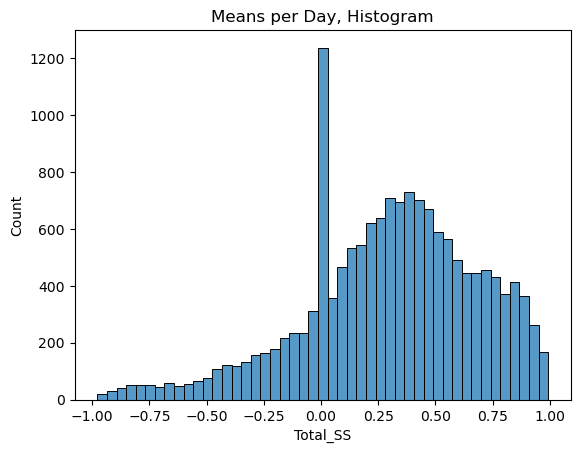

In [11]:
sns.histplot(df_mean['Total_SS'])
plt.title('Means per Day, Histogram')

Text(0.5, 1.0, 'Standard-Deviations per Day, Histogram')

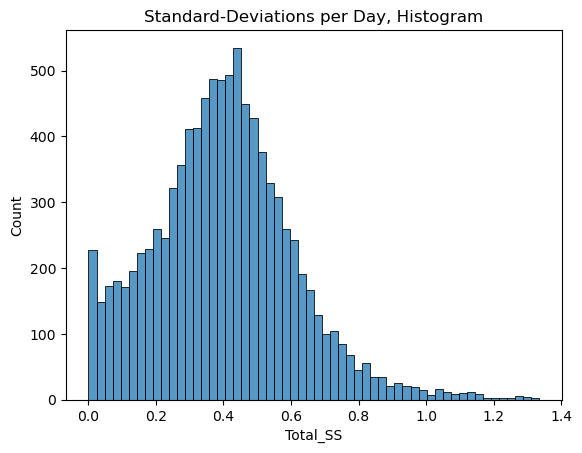

In [12]:
sns.histplot(df_std['Total_SS'])
plt.title('Standard-Deviations per Day, Histogram')

As Kenneth mentioned, we see that the standard deviation is hovering around .4, while the mean is concentrated around 0 and skewed left. There might be something worth looking into here. 

We could also plot the mean and standard deviations of the other scores (i.e. neg, neut, pos) via a similar line of code.


TBD: Further groupby sector if needed

# Preliminary Graphs
Let's try doing some simple graphs to understand the data a bit more. In this section, we will try to understand the data on the singular stock level. 
The chosen stock for these examples is AAPL, but this can be easily modified. 

Let's start by plotting the date of the article to the total sentiment score. 

WARNING: Graphs are not made pretty, just basic

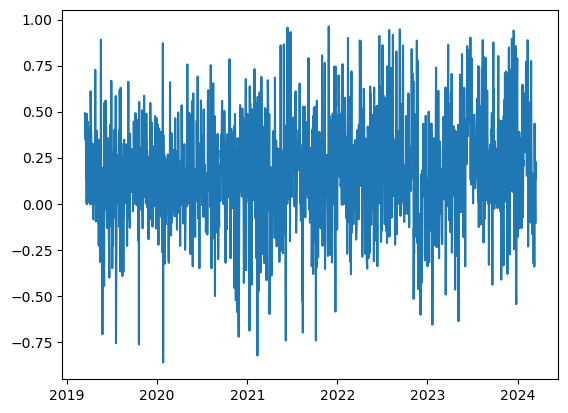

In [13]:
df_aapl = df_mean[df_mean['Ticker'] == 'AAPL'].reset_index()
plt.plot(df_aapl['New_Date'], df_aapl['Total_SS'])

This is pretty messy, and it's a little hard to figure out what is going on here. Let's just zoom into a specific year to see if we can find some patterns.

[]

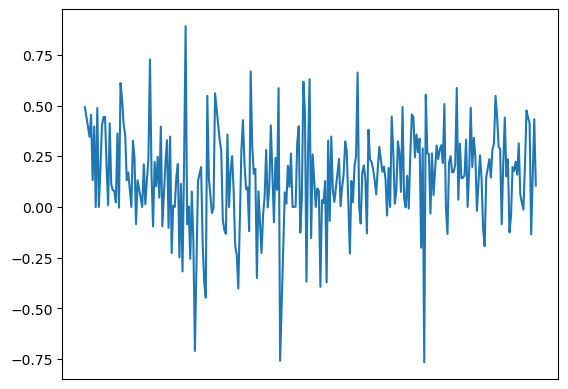

In [14]:
#Note there are missing days in dataset. The following line of code returns those missing for our stock, in case we ever need it
pd.date_range(start = '2019-03-15', end = '2024-03-15' ).difference(df_aapl['New_Date'])

df_aapl_2019 = df_aapl[df_aapl['New_Date'].apply(lambda x: x.year == 2019)]

fig, ax = plt.subplots()
labels = df_aapl_2019['New_Date'].apply(lambda x: (x.month, x.day))

plt.plot(df_aapl_2019['New_Date'], df_aapl_2019['Total_SS'])
ax.set_xticks([])

Not really any better. I guess maybe it's not obvious there would be a pattern in the news. Maybe there are expected highs and lows based on events, such as new Apple product announcements in the fall and spring. 

Let's start looking at autocorrelation factors in our time series to determine if there are time lapse correlations. This seems a little more expected, since one would assume that some news articles being positive or negative might spill over into nearby days. 

This is the Autocorrelation, with default parameters


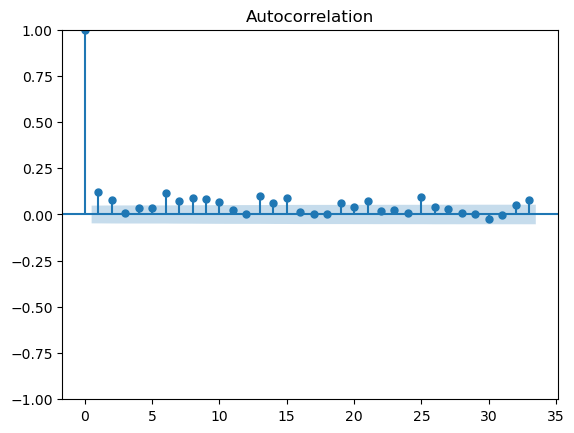

In [15]:
plot_acf(df_aapl['Total_SS'])
print('This is the Autocorrelation, with default parameters')

This is partial Autocorrelation, again with default parameters


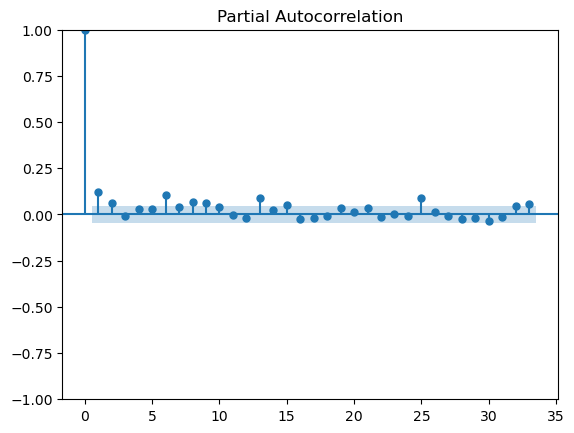

In [16]:
plot_pacf(df_aapl['Total_SS'])
print('This is partial Autocorrelation, again with default parameters')

These graphs seem to indicate that maybe there is some correlation within the first two days, although the second day seems a little suspicious. Would have to vary the stock, and would ideally want to look at stock price as well. For now, a conservative one day lag might be ideal. 

# Simpler Graphs

Let's try to do the graphs again, but this time just look at the labelled sentiment score we defined earlier (i.e. neg, neut, pos). We again use AAPL here.

Because of the way the averaging in the means were done, we should reapply the labelling function.

In [17]:
df_aapl['Label_SS'] = df_aapl['Label_SS'].apply(lambda x: label_sentiment(x))
df_aapl_2019['Label_SS'] = df_aapl_2019['Label_SS'].apply(lambda x: label_sentiment(x))

/var/folders/tg/nkrt27q937bgzsnrzszxn7bc0000gn/T/ipykernel_6094/1255165724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl_2019['Label_SS'] = df_aapl_2019['Label_SS'].apply(lambda x: label_sentiment(x))


([], [])

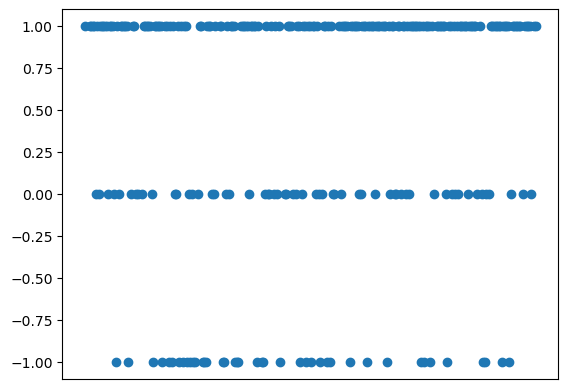

In [18]:
plt.scatter(df_aapl_2019['New_Date'], df_aapl_2019['Label_SS'])
plt.xticks([])

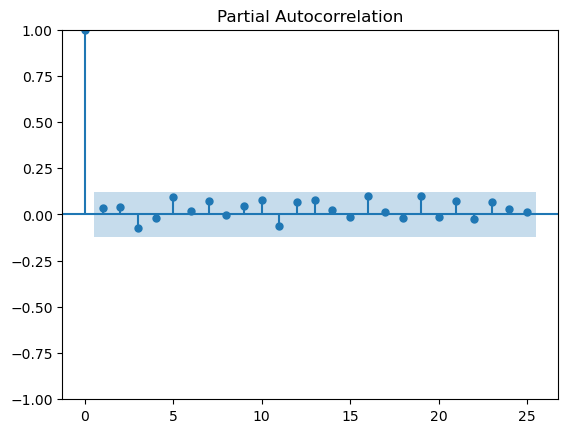

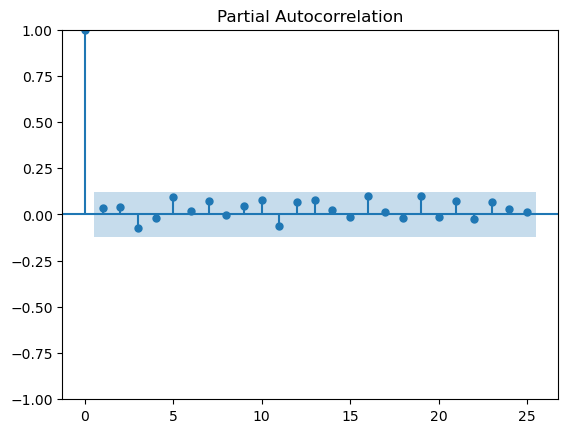

In [19]:
plot_pacf(df_aapl_2019['Label_SS'])

... Maybe not useful... Maybe this section should be revisited or removed in the future.

For now, maybe length of positive, negative, and neutrals might be better

In [20]:
label_data_date= df.groupby(['New_Date', 'Ticker'])['Label_SS'].value_counts()
label_data = df.groupby(['Ticker'])['Label_SS'].value_counts()
label_data

Ticker  Label_SS
AAPL     1           6707
        -1           3372
         0           2912
ABBV     1            924
        -1            317
         0            211
AMZN     1          10567
        -1           2407
         0           1055
BAC      1           1160
        -1            308
         0            289
GOOGL    1           4301
        -1           2348
         0           1667
JNJ      1           1135
        -1            627
         0            451
JPM      1           1522
        -1            567
         0            419
LLY      1           1023
        -1            355
         0            315
MA       1           1096
         0            277
        -1            139
MRK      1            903
        -1            430
         0            369
MSFT     1           3749
         0           1138
        -1           1047
NVDA     1           3428
         0            941
        -1            810
UNH      1            786
         0           

Is there interesting trends here? Is positive news much more common than negative news, for instance? 
Let's just compute positivity rates. 

In [21]:
positivity_rates = {}
for tick in tickers:
    positivity_rates[tick] = label_data[(tick, 1)] / (label_data[tick, 1]+label_data[tick, 0]+label_data[tick, -1])
positivity_rates


{'WFC': 0.7988950276243094,
 'AAPL': 0.516280501885921,
 'MA': 0.7248677248677249,
 'BAC': 0.6602162777461582,
 'GOOGL': 0.5171957671957672,
 'AMZN': 0.7532254615439447,
 'JPM': 0.6068580542264753,
 'MSFT': 0.6317829457364341,
 'V': 0.72674791533034,
 'ABBV': 0.6363636363636364,
 'NVDA': 0.6619038424406256,
 'LLY': 0.6042528056704075,
 'MRK': 0.5305522914218567,
 'UNH': 0.7492850333651097,
 'JNJ': 0.5128784455490285}

Seems the answer is yes, with the least positive being AAPL and JNJ. 

# Moving Averages

Perhaps we want to look at the data with moving averages. We can do both non-weighted and weighted rolling averages. 

Some Questions:
How much should we move by? 
How much should we weigh by?

For now, lets do rolling average over 180 days. Other possiblilities are a week, a month, or longer. I'll try to make the code general so this is easily modified. As usual, the default stock here is AAPL, which can be changed in the first line

First, we need to deal with the fact that stocks have missing days. Let's fill in the missing data as rows with NANs

In [22]:
df_time = pd.DataFrame(pd.date_range(start = '2019-03-15', end = '2024-03-15' ), columns = ['New_Date'])

#Change the stock to others if needed
df_stock = df_mean[df_mean['Ticker'] == 'AAPL'].reset_index().drop(columns = ['Ticker', 'index'])

df_stock = pd.merge(df_stock, df_time, on = 'New_Date', how ='outer')
df_stock.set_index('New_Date', inplace = True)
df_stock.head()

#NOTE: Since our indexes are timeseries, it's probably enough to just make the dates the indexes and roll with a timedelta object. But I already wrote this, so 
#i'll keep this naive production for now

,Negative_SS,Neutral_SS,Positive_SS,Total_SS,Label_SS
New_Date,,,,,
2019-03-15,0.000000,0.799667,0.200333,0.491367,0.666667
2019-03-16,NaN,NaN,NaN,NaN,NaN
2019-03-17,NaN,NaN,NaN,NaN,NaN
2019-03-18,0.025125,0.852875,0.121875,0.345788,0.625000
2019-03-19,0.039900,0.772300,0.187700,0.453680,0.700000


Now let's restrict to the total sentiment scores and do a 180 day rolling average

In [23]:
#df_roll looks at previous 180 days and averages the means based on that. if there are less than 180 days, it takes whatever it has. it also ignores nans
df_roll = df_stock.rolling(window = 180, min_periods=1).apply(np.nanmean)
df_roll.head()


,Negative_SS,Neutral_SS,Positive_SS,Total_SS,Label_SS
New_Date,,,,,
2019-03-15,0.000000,0.799667,0.200333,0.491367,0.666667
2019-03-16,0.000000,0.799667,0.200333,0.491367,0.666667
2019-03-17,0.000000,0.799667,0.200333,0.491367,0.666667
2019-03-18,0.012563,0.826271,0.161104,0.418577,0.645833
2019-03-19,0.021675,0.808281,0.169969,0.430278,0.663889


Text(0.5, 1.0, 'rolling averages (including first 180)')

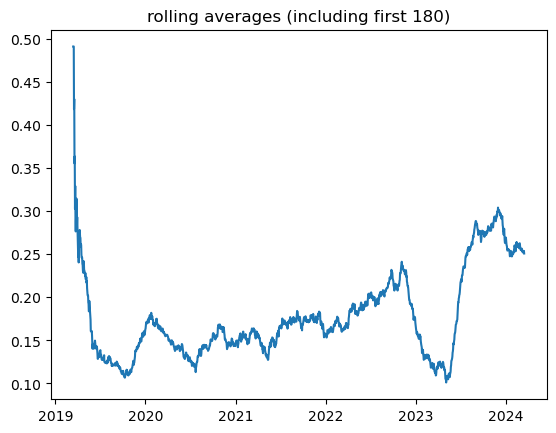

In [24]:
# fig, ax = plt.subplots()
plt.plot(df_roll.index, df_roll['Total_SS'])
plt.title('rolling averages (including first 180)')

Text(0.5, 1.0, 'rolling averages, day 180 onwards')

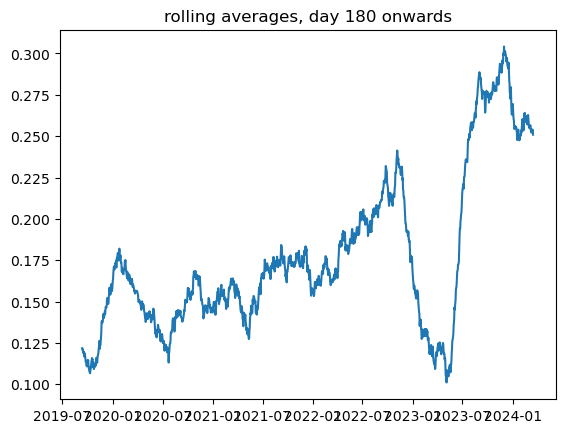

In [25]:
# fig, ax = plt.subplots()
plt.plot(df_roll.index[180:], df_roll['Total_SS'][180:])
plt.title('rolling averages, day 180 onwards')

Partial Autocorrelation for the rolling dataframe


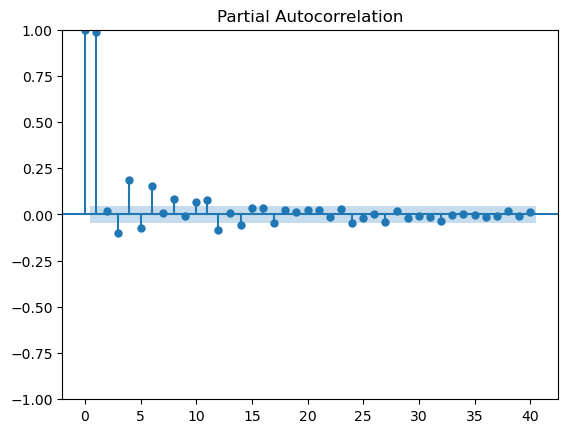

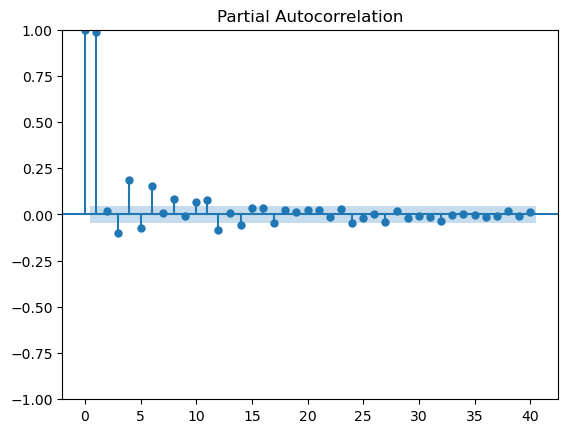

In [26]:
plot_pacf(df_roll['Total_SS'], lags = 40)

# Other Questions to Consider

Should we examine news sites a bit better? Possible some sites use give out more positive articles than others. This is perhaps too complicated for the current project, might be a good future direction (Related to finding which sites have most influence over stock prices)

Find outliers in the mean data, see if these news sources have more affect on the stock prices 